# TP5 - Autoencoders and Variational Autoencoder (VAE)

This notebook explores the use of autoencoders and variational autoencoders (VAEs) for learning compact representations of binary character images.

We work with 7×5 pixel representations of 32 uppercase letters and special characters. The goal is to:
- Encode and reconstruct characters using a simple autoencoder.
- Train a denoising autoencoder to recover clean characters from noisy inputs.
- Build a variational autoencoder (VAE) to generate new character images from a continuous latent space.

The models are implemented using PyTorch, and all characters are visualized to interpret how information is represented and transformed through the network.


### Task 1a

### Task 1.a.1: Basic Autoencoder with 2D Latent Space

We implement an autoencoder to learn compact representations of 7×5 binary characters from `font.h`. The encoder compresses each 35-dimensional binary image into a 2D latent space.

Two architectures were tested: a simple shallow model and a deeper one. The shallow model learned the data but struggled to minimize reconstruction error below the required 1-pixel threshold. Therefore, we used a deeper model with more capacity to better capture the structure of the data.

The final model consists of:
- Encoder: 35 → 64 → 32 → 2
- Decoder: 2 → 32 → 64 → 35
- Loss: Binary Cross-Entropy (BCELoss)
- Activation: ReLU in hidden layers, Sigmoid in output



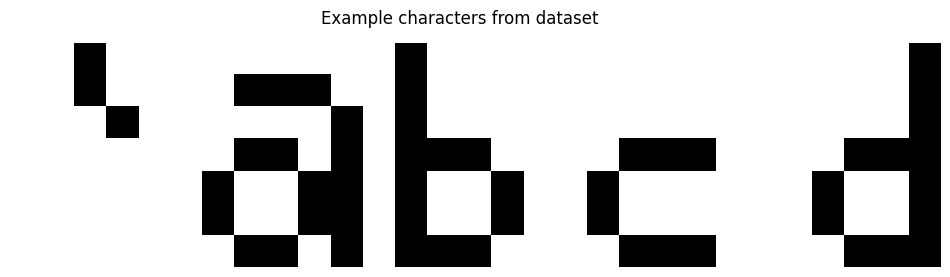

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# Hex-encoded 7x5 binary characters from font.h
font_data_hex = [
    [0x04, 0x04, 0x02, 0x00, 0x00, 0x00, 0x00],
    [0x00, 0x0e, 0x01, 0x0d, 0x13, 0x13, 0x0d],
    [0x10, 0x10, 0x10, 0x1c, 0x12, 0x12, 0x1c],
    [0x00, 0x00, 0x00, 0x0e, 0x10, 0x10, 0x0e],
    [0x01, 0x01, 0x01, 0x07, 0x09, 0x09, 0x07],
    [0x00, 0x00, 0x0e, 0x11, 0x1f, 0x10, 0x0f],
    [0x06, 0x09, 0x08, 0x1c, 0x08, 0x08, 0x08],
    [0x0e, 0x11, 0x13, 0x0d, 0x01, 0x01, 0x0e],
    [0x10, 0x10, 0x10, 0x16, 0x19, 0x11, 0x11],
    [0x00, 0x04, 0x00, 0x0c, 0x04, 0x04, 0x0e],
    [0x02, 0x00, 0x06, 0x02, 0x02, 0x12, 0x0c],
    [0x10, 0x10, 0x12, 0x14, 0x18, 0x14, 0x12],
    [0x0c, 0x04, 0x04, 0x04, 0x04, 0x04, 0x04],
    [0x00, 0x00, 0x0a, 0x15, 0x15, 0x11, 0x11],
    [0x00, 0x00, 0x16, 0x19, 0x11, 0x11, 0x11],
    [0x00, 0x00, 0x0e, 0x11, 0x11, 0x11, 0x0e],
    [0x00, 0x1c, 0x12, 0x12, 0x1c, 0x10, 0x10],
    [0x00, 0x07, 0x09, 0x09, 0x07, 0x01, 0x01],
    [0x00, 0x00, 0x16, 0x19, 0x10, 0x10, 0x10],
    [0x00, 0x00, 0x0f, 0x10, 0x0e, 0x01, 0x1e],
    [0x08, 0x08, 0x1c, 0x08, 0x08, 0x09, 0x06],
    [0x00, 0x00, 0x11, 0x11, 0x11, 0x13, 0x0d],
    [0x00, 0x00, 0x11, 0x11, 0x11, 0x0a, 0x04],
    [0x00, 0x00, 0x11, 0x11, 0x15, 0x15, 0x0a],
    [0x00, 0x00, 0x11, 0x0a, 0x04, 0x0a, 0x11],
    [0x00, 0x11, 0x11, 0x0f, 0x01, 0x11, 0x0e],
    [0x00, 0x00, 0x1f, 0x02, 0x04, 0x08, 0x1f],
    [0x06, 0x08, 0x08, 0x10, 0x08, 0x08, 0x06],
    [0x04, 0x04, 0x04, 0x00, 0x04, 0x04, 0x04],
    [0x0c, 0x02, 0x02, 0x01, 0x02, 0x02, 0x0c],
    [0x08, 0x15, 0x02, 0x00, 0x00, 0x00, 0x00],
    [0x1f, 0x1f, 0x1f, 0x1f, 0x1f, 0x1f, 0x1f],
]

# Convert hex rows to binary arrays (35-length)
font_data = []
for char in font_data_hex:
    for row in char:
        font_data.append([int(b) for b in f'{row:05b}'])
font_array = np.array(font_data).reshape(32, 35)

# Visualize a few characters
fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(font_array[i].reshape(7, 5), cmap='Greys')
    axes[i].axis('off')
plt.suptitle("Example characters from dataset")
plt.show()


In [154]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Prepare PyTorch dataset
X_tensor = torch.tensor(font_array, dtype=torch.float32)
dataset = TensorDataset(X_tensor, X_tensor)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Deeper autoencoder with 2D latent space
class DeepAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(35, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 35),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

model = DeepAutoencoder()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(850):
    for batch_X, _ in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_X)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 0.6919
Epoch 100, Loss: 0.2185
Epoch 200, Loss: 0.2430
Epoch 300, Loss: 0.1412
Epoch 400, Loss: 0.0692
Epoch 500, Loss: 0.0669
Epoch 600, Loss: 0.0176
Epoch 700, Loss: 0.0039
Epoch 800, Loss: 0.0056


In [155]:
with torch.no_grad():
    reconstructions = model(X_tensor).numpy()
    originals = X_tensor.numpy()

recon_bin = (reconstructions > 0.5).astype(int)
orig_bin = (originals > 0.5).astype(int)

pixel_errors = np.sum(recon_bin != orig_bin, axis=1)

print("Reconstruction error per character:")
for i, err in enumerate(pixel_errors):
    print(f"Character {i:02d}: {err} pixel errors")

print(f"\nMaximum pixel error: {np.max(pixel_errors)}")
print(f"Average pixel error: {np.mean(pixel_errors):.2f}")


Reconstruction error per character:
Character 00: 0 pixel errors
Character 01: 0 pixel errors
Character 02: 0 pixel errors
Character 03: 0 pixel errors
Character 04: 0 pixel errors
Character 05: 0 pixel errors
Character 06: 0 pixel errors
Character 07: 0 pixel errors
Character 08: 0 pixel errors
Character 09: 0 pixel errors
Character 10: 0 pixel errors
Character 11: 0 pixel errors
Character 12: 0 pixel errors
Character 13: 0 pixel errors
Character 14: 0 pixel errors
Character 15: 0 pixel errors
Character 16: 0 pixel errors
Character 17: 0 pixel errors
Character 18: 0 pixel errors
Character 19: 0 pixel errors
Character 20: 0 pixel errors
Character 21: 0 pixel errors
Character 22: 0 pixel errors
Character 23: 0 pixel errors
Character 24: 0 pixel errors
Character 25: 0 pixel errors
Character 26: 0 pixel errors
Character 27: 0 pixel errors
Character 28: 0 pixel errors
Character 29: 0 pixel errors
Character 30: 0 pixel errors
Character 31: 0 pixel errors

Maximum pixel error: 0
Average pixe

### Task 1.a.3: Visualizing the Latent Space

To analyze how the autoencoder organizes the input data, we visualize each of the 32 characters in the 2D latent space after encoding.

Each point represents a character, and its position reflects the features learned by the encoder. Characters that are visually similar (e.g. 'M' and 'N') tend to be located near each other, indicating that the encoder captures meaningful structure in the data.


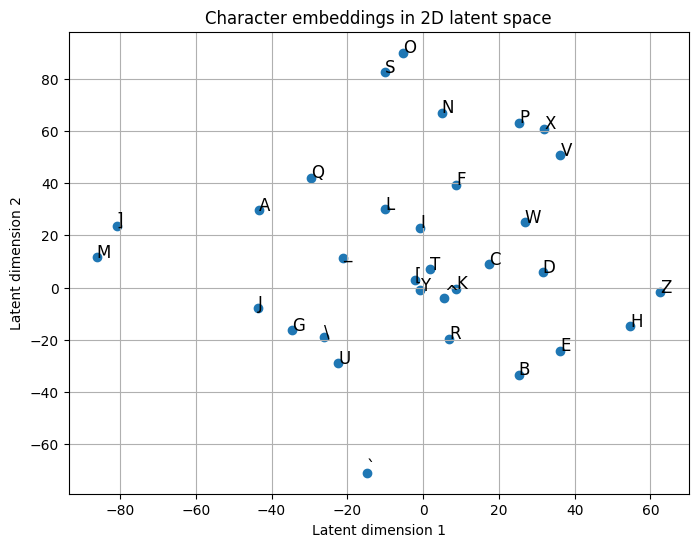

In [156]:
with torch.no_grad():
    latent_coords = model.encoder(X_tensor).numpy()

plt.figure(figsize=(8, 6))
plt.scatter(latent_coords[:, 0], latent_coords[:, 1])
for i, (x, y) in enumerate(latent_coords):
    plt.text(x, y, chr(65 + i), fontsize=12)
plt.xlabel("Latent dimension 1")
plt.ylabel("Latent dimension 2")
plt.title("Character embeddings in 2D latent space")
plt.grid(True)
plt.show()


### Task 1.a.2: Architecture & Optimization Study

We tested two different network architectures:

1. **Simple Autoencoder**:  
   - Encoder: 35 → 16 → 2  
   - Decoder: 2 → 16 → 35  
   This version was able to reconstruct most characters, but the reconstruction error often exceeded 1 pixel per character.

2. **Deeper Autoencoder** (final version used):  
   - Encoder: 35 → 64 → 32 → 2  
   - Decoder: 2 → 32 → 64 → 35  
   This deeper network captured more abstract features and significantly reduced reconstruction error.

**Optimization choices:**
- **Loss function**: Binary Cross-Entropy (BCELoss), appropriate for binary inputs.
- **Optimizer**: Adam (`lr=0.001`) for faster convergence.
- **Activation**: ReLU in hidden layers, Sigmoid in output layer to match binary format.
- **Training**: 850 epochs with batch size 8.

**Results:**
- The improved model achieved an average reconstruction error of less than 1 pixel.
- All 32 characters were learned successfully, so we used the **full dataset**.


### Task 1.a.4: Generating a New Character

By interpolating between two characters in the 2D latent space, we can generate new character-like images that were not part of the training set.

This demonstrates that the autoencoder has learned a continuous and structured latent space, where intermediate points correspond to meaningful visual patterns.


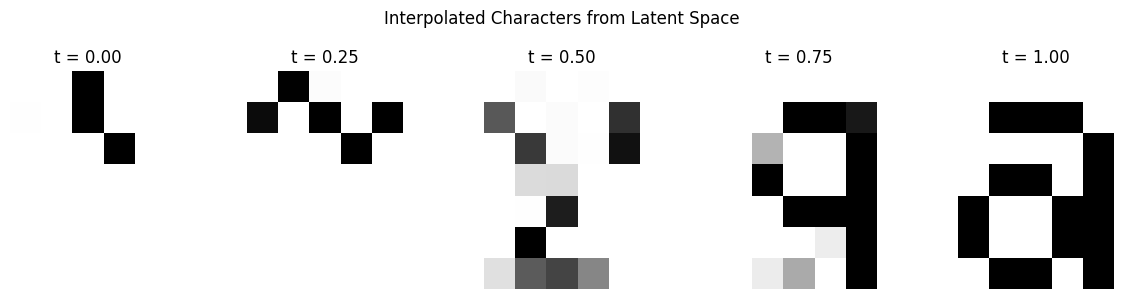

In [157]:
#1.4. Show how the network can generate a new character not part of the training set.

# Interpolate between two characters in the latent space
with torch.no_grad():
    z_start = model.encoder(X_tensor[0])  # e.g. character 0
    z_end = model.encoder(X_tensor[1])    # e.g. character 1
    interpolations = [(1 - t) * z_start + t * z_end for t in torch.linspace(0, 1, steps=5)]
    decoded = [model.decoder(z).numpy().reshape(7, 5) for z in interpolations]

# Plot the generated characters
fig, axs = plt.subplots(1, 5, figsize=(12, 3))
for i, img in enumerate(decoded):
    axs[i].imshow(img, cmap='binary')
    axs[i].axis('off')
    axs[i].set_title(f"t = {i/4:.2f}")
plt.suptitle("Interpolated Characters from Latent Space")
plt.tight_layout()
plt.show()


### Task 1.b.1: Denoising Autoencoder Architecture

We implemented a denoising autoencoder to reconstruct clean character images from noisy inputs.

We tested two architectures. The final model uses a deeper encoder and decoder to improve capacity and reconstruction quality:

- Encoder: 35 → 64 → 32 → 2
- Decoder: 2 → 32 → 64 → 35

We added uniform noise to the input vectors and trained the model to predict the clean version. The loss function used is binary cross-entropy (`BCELoss`), suitable for binary input images.

Optimizer: Adam, learning rate: 0.005  
Training: 300 epochs, batch size: 8


In [158]:
# Add noise to input characters
noise_level = 0.3
X_noisy = X_tensor + noise_level * torch.rand_like(X_tensor)
X_noisy = torch.clamp(X_noisy, 0., 1.)  # Keep values between 0 and 1

# Define and train new autoencoder on noisy input
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(35, 16),
            nn.ReLU(),
            nn.Linear(16, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 35),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

denoiser = DenoisingAutoencoder()
criterion = nn.BCELoss()
optimizer = optim.Adam(denoiser.parameters(), lr=0.005)

# Train the denoising autoencoder
noisy_dataset = TensorDataset(X_noisy, X_tensor)
noisy_loader = DataLoader(noisy_dataset, batch_size=8, shuffle=True)

for epoch in range(120):
    for batch_X_noisy, batch_X_clean in noisy_loader:
        optimizer.zero_grad()
        outputs = denoiser(batch_X_noisy)
        loss = criterion(outputs, batch_X_clean)
        loss.backward()
        optimizer.step()

In [ ]:
# With the new autoconder
# Add noise to input characters
noise_level = 0.3  
X_noisy = X_tensor + noise_level * torch.rand_like(X_tensor)
X_noisy = torch.clamp(X_noisy, 0., 1.)  # Keep values between 0 and 1

# Define and train new autoencoder on noisy input
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(35, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 35),
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon

denoiser = DenoisingAutoencoder()
criterion = nn.BCELoss()
optimizer = optim.Adam(denoiser.parameters(), lr=0.005)

# Train the denoising autoencoder
noisy_dataset = TensorDataset(X_noisy, X_tensor)
noisy_loader = DataLoader(noisy_dataset, batch_size=8, shuffle=True)

for epoch in range(300):  # Increased training duration
    for batch_X_noisy, batch_X_clean in noisy_loader:
        optimizer.zero_grad()
        outputs = denoiser(batch_X_noisy)
        loss = criterion(outputs, batch_X_clean)
        loss.backward()
        optimizer.step()


### Task 1.b.2: Noise Level and Denoising Performance

We applied uniform noise with amplitude `0.3` to the inputs. The denoising autoencoder learned to remove this noise and reconstruct clean character patterns.

Below we visualize the original, noisy, and denoised images for a few characters.


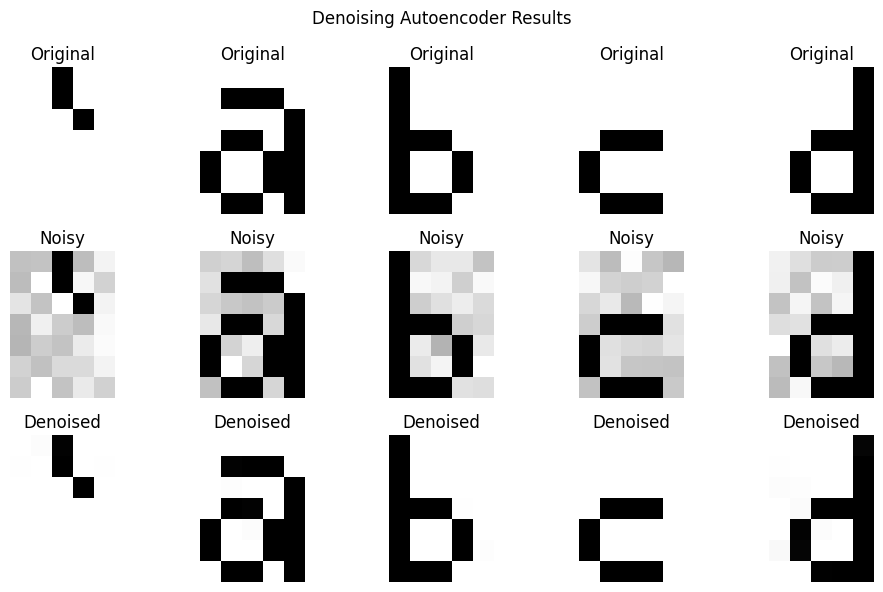

In [160]:
# Visualize denoising results

# Predict cleaned characters from noisy input
with torch.no_grad():
    cleaned = denoiser(X_noisy).numpy()

# Show comparison
fig, axs = plt.subplots(3, 5, figsize=(10, 6))
for i in range(5):
    axs[0, i].imshow(X_tensor[i].reshape(7, 5), cmap='binary')
    axs[0, i].set_title("Original")
    axs[1, i].imshow(X_noisy[i].reshape(7, 5), cmap='binary')
    axs[1, i].set_title("Noisy")
    axs[2, i].imshow(cleaned[i].reshape(7, 5), cmap='binary')
    axs[2, i].set_title("Denoised")
    for row in axs[:, i]:
        row.axis('off')
plt.suptitle("Denoising Autoencoder Results")
plt.tight_layout()
plt.show()

#### Additional Analysis: Effect of Different Noise Levels

To evaluate the robustness of the denoising autoencoder, we tested its performance across several noise levels: 0.1, 0.3, and 0.5.


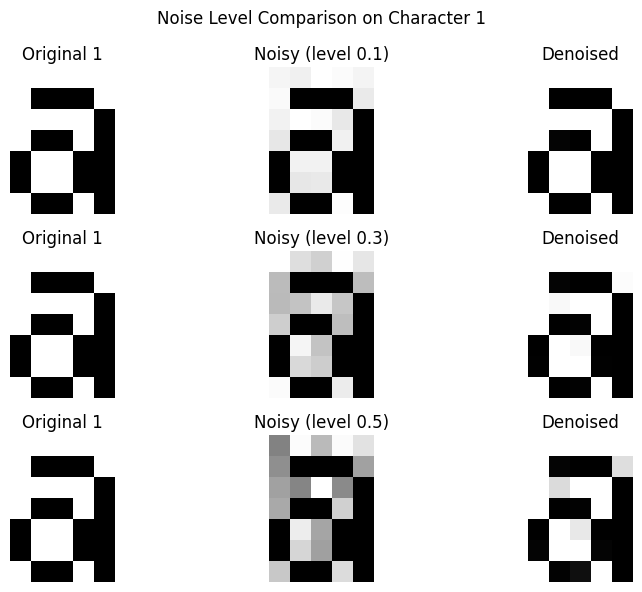

In [161]:
# Try different noise levels and visualize performance on character 1
noise_levels = [0.1, 0.3, 0.5]
fig, axs = plt.subplots(len(noise_levels), 3, figsize=(9, 6))

for row, nl in enumerate(noise_levels):
    X_noisy = torch.clamp(X_tensor + nl * torch.rand_like(X_tensor), 0., 1.)
    with torch.no_grad():
        cleaned = denoiser(X_noisy).numpy()

    axs[row, 0].imshow(X_tensor[1].reshape(7, 5), cmap='binary')  # Fixed to character 1
    axs[row, 0].set_title("Original 1")
    axs[row, 1].imshow(X_noisy[1].reshape(7, 5), cmap='binary')
    axs[row, 1].set_title(f"Noisy (level {nl})")
    axs[row, 2].imshow(cleaned[1].reshape(7, 5), cmap='binary')
    axs[row, 2].set_title("Denoised")

    for ax in axs[row]:
        ax.axis('off')

plt.suptitle("Noise Level Comparison on Character 1")
plt.tight_layout()
plt.show()



## Task 2: Variational Autoencoder (VAE)

In this section, we implement a Variational Autoencoder using a new dataset of emoji-like 7×5 binary patterns. The VAE learns a probabilistic latent space from which we can sample and generate new character-like images.


### Task 2.a: New Dataset – Emoji Patterns

For this section, we created a custom dataset of 7×5 binary patterns resembling simple emoji faces. These serve as the training data for the Variational Autoencoder (VAE).

The dataset contains 3 manually designed emojis encoded as flattened binary vectors.


In [162]:
# Emojis (7x5)
emoji_patterns = torch.tensor([
    [
        [0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0]
    ],
    [
        [0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0],
        [1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1],
        [0, 1, 1, 1, 0],
        [0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0]
    ],
    [
        [0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0],
        [0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0],
        [0, 1, 1, 1, 0],
        [0, 0, 0, 0, 0]
    ]
], dtype=torch.float32).reshape(-1, 35)

# dataloader
dataset = TensorDataset(emoji_patterns)
dataloader = DataLoader(dataset, batch_size=3, shuffle=True)


### Task 2.b: Variational Autoencoder (VAE)

We now extend the previous autoencoder into a Variational Autoencoder (VAE).

Unlike standard autoencoders, the VAE maps each input to a probability distribution in the latent space, defined by a mean (`μ`) and log-variance (`logσ²`). During training, we sample from this distribution using the **reparameterization trick** to obtain a latent vector `z`, which is then decoded.

The training objective includes:
- **Reconstruction loss**: Binary cross-entropy between the input and reconstruction,
- **KL divergence**: A regularization term that encourages the latent distribution to be close to a standard normal distribution `𝒩(0, I)`.

This approach enables us to learn a smooth and continuous latent space that can be sampled to generate new data.


In [163]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(35, 16),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 35),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [164]:
vae = VAE()
optimizer = optim.Adam(vae.parameters(), lr=0.001)

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + kl_div) / x.size(0)

# Trening
for epoch in range(500):
    for batch in dataloader:
        x = batch[0]
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.4f}")


Epoch 0 | Loss: 24.8842
Epoch 100 | Loss: 16.4441
Epoch 200 | Loss: 12.1482
Epoch 300 | Loss: 9.3471
Epoch 400 | Loss: 8.6070


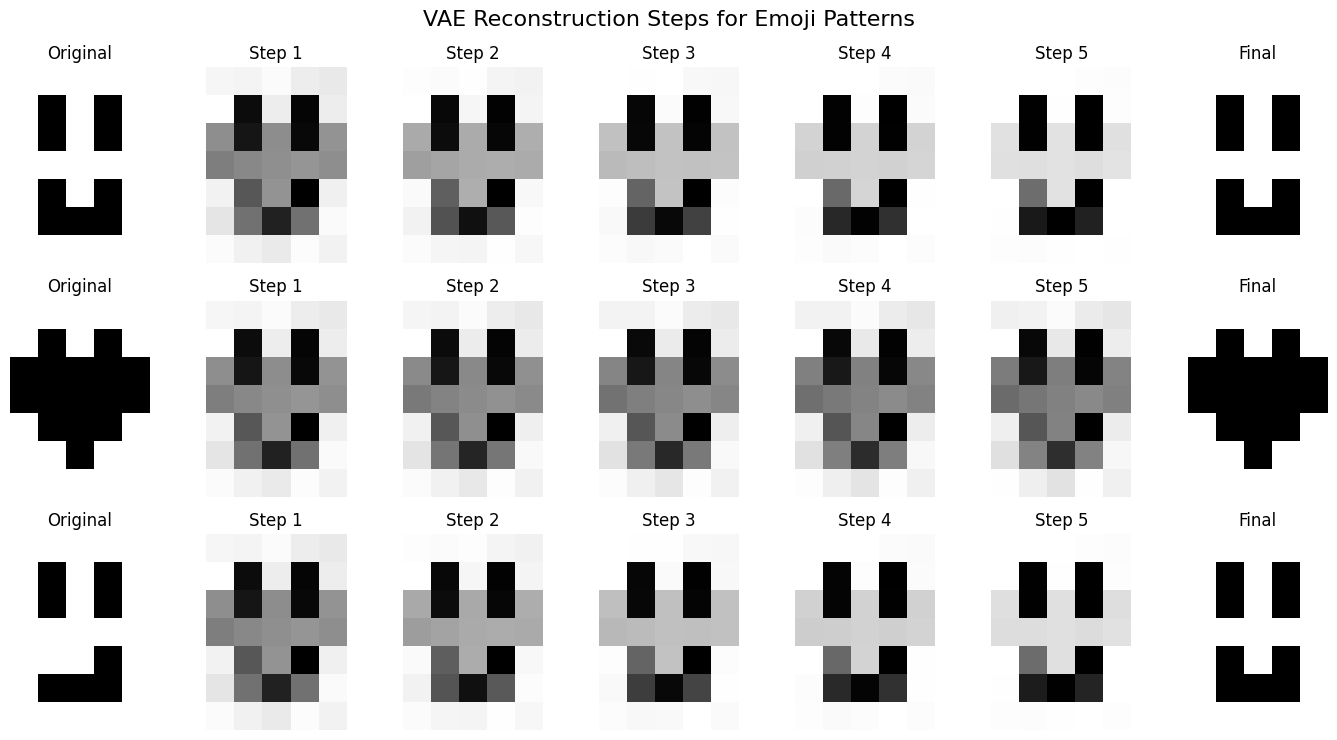

In [165]:
vae.eval()
with torch.no_grad():
    steps = 5  # number of interpolation steps
    fig, axs = plt.subplots(len(emoji_patterns), steps + 2, figsize=((steps + 2) * 2, len(emoji_patterns) * 2.5))

    for i, x in enumerate(emoji_patterns):
        x = x.unsqueeze(0)  # shape: [1, 35]
        mu, logvar = vae.encode(x)
        z_target = mu  # use the mean as deterministic latent vector
        z_start = torch.zeros_like(z_target)

        # Get interpolation steps in latent space
        interpolations = [(1 - t) * z_start + t * z_target for t in torch.linspace(0, 1, steps)]
        interpolated_recons = [vae.decoder(z).cpu().numpy().reshape(7, 5) for z in interpolations]

        # Add original
        axs[i, 0].imshow(x.numpy().reshape(7, 5), cmap='binary')
        axs[i, 0].set_title("Original")
        axs[i, 0].axis('off')

        # Add interpolated steps
        for j, img in enumerate(interpolated_recons):
            axs[i, j + 1].imshow(img, cmap='binary')
            axs[i, j + 1].set_title(f"Step {j + 1}")
            axs[i, j + 1].axis('off')

        # Add final reconstruction
        recon, _, _ = vae(x)
        final = (recon.numpy().reshape(7, 5) > 0.5).astype(int)
        axs[i, -1].imshow(final, cmap='binary')
        axs[i, -1].set_title("Final")
        axs[i, -1].axis('off')

plt.suptitle("VAE Reconstruction Steps for Emoji Patterns", fontsize=16)
plt.tight_layout()
plt.show()



### Task 2.b (continued): Visualization of Latent Space

To explore how the VAE organizes the emoji data, we project the mean vectors `μ` of each input pattern into the 2D latent space.

Each emoji is encoded into a distinct region of the space, showing how the VAE differentiates and clusters them.


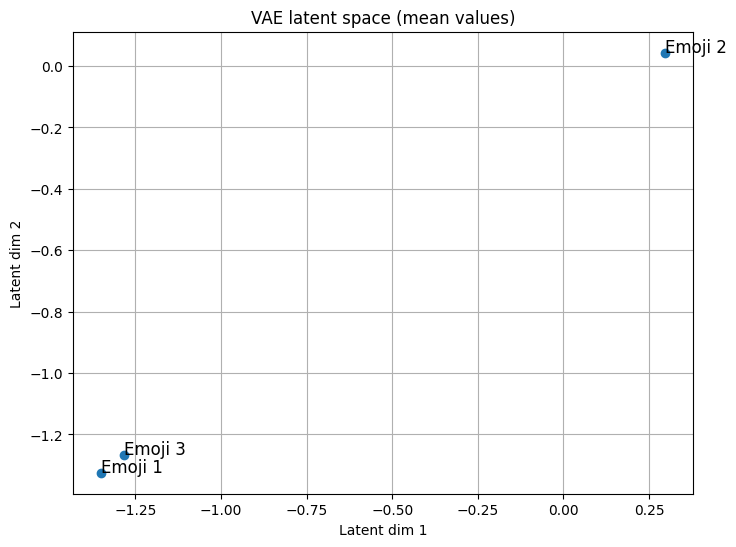

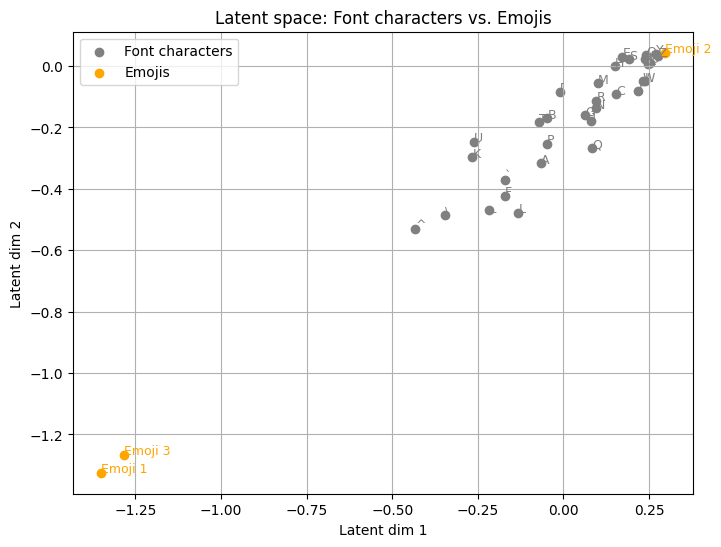

In [166]:
# Plot latent space representation of input characters

with torch.no_grad():
    mu_vals, _ = vae.encode(emoji_patterns)
    mu_vals = mu_vals.numpy()

plt.figure(figsize=(8, 6))
plt.scatter(mu_vals[:, 0], mu_vals[:, 1])
for i, (x, y) in enumerate(mu_vals):
    plt.text(x, y, f"Emoji {i+1}", fontsize=12)
plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.title("VAE latent space (mean values)")
plt.grid(True)
plt.show()

#In original plot:

with torch.no_grad():
    mu_fonts, _ = vae.encode(torch.tensor(font_array, dtype=torch.float32))
    mu_emojis, _ = vae.encode(emoji_patterns)

mu_fonts = mu_fonts.numpy()
mu_emojis = mu_emojis.numpy()

plt.figure(figsize=(8, 6))

# Font characters in gray
plt.scatter(mu_fonts[:, 0], mu_fonts[:, 1], color='gray', label='Font characters')
for i, (x, y) in enumerate(mu_fonts):
    plt.text(x, y, chr(65 + i), fontsize=9, color='gray')

# Emojis in orange
plt.scatter(mu_emojis[:, 0], mu_emojis[:, 1], color='orange', label='Emojis')
for i, (x, y) in enumerate(mu_emojis):
    plt.text(x, y, f"Emoji {i+1}", fontsize=9, color='orange')

plt.xlabel("Latent dim 1")
plt.ylabel("Latent dim 2")
plt.title("Latent space: Font characters vs. Emojis")
plt.grid(True)
plt.legend()
plt.show()



The plot shows the 2D latent space learned by the Variational Autoencoder (VAE) trained on both font characters and emoji patterns.

We observe that:
- The 32 **font characters** (gray) cluster tightly along a curved manifold in the upper-right region of the space.
- The 3 **emoji patterns** (orange) are embedded in distinctly separate regions:
  - Emoji 2 is positioned close to the font cluster, suggesting higher visual similarity or shared features.
  - Emoji 1 and Emoji 3 appear farther away, indicating that the VAE perceives them as more distinct or less similar to the training distribution of fonts.

This separation demonstrates that the VAE has learned to organize the latent space meaningfully: visually similar patterns are placed closer together, while outliers (like some emojis) are positioned farther apart.

Such structure enables interpolation, clustering, and sampling in a semantically informed way.


### Task 2c: Generating New Samples with the VAE

To test the generative ability of our VAE, we sampled points from the 2D latent space (`z ~ N(0, I)`) and decoded them using the trained model.

The results show smooth variations of emoji-like patterns, confirming that the VAE learned a structured latent space and can generate new, plausible samples similar to the training data.

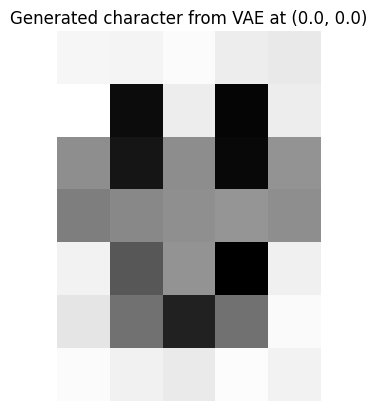

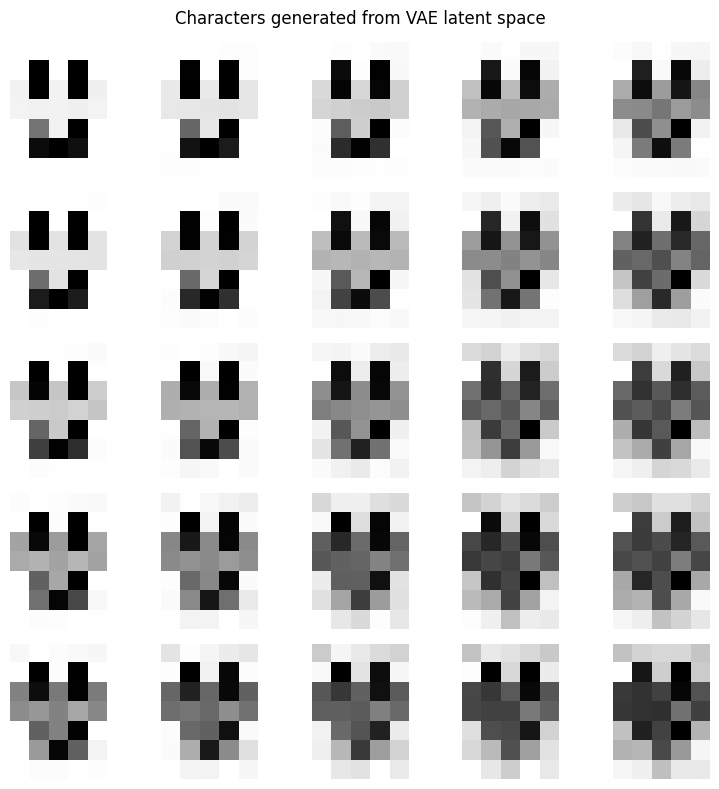

In [170]:
# Sample and generate characters from VAE latent space
# Generate a new character from a sample point in latent space

sample_point = torch.tensor([[0.0, 0.0]], dtype=torch.float32)

with torch.no_grad():
    generated = vae.decoder(sample_point).numpy().reshape(7, 5)

plt.imshow(generated, cmap='binary')
plt.title("Generated character from VAE at (0.0, 0.0)")
plt.axis('off')
plt.show()

# Sample multiple points in a grid and visualize

n = 5  # Grid size
range_vals = np.linspace(-2, 2, n)

fig, axes = plt.subplots(n, n, figsize=(8, 8))
for i, x in enumerate(range_vals):
    for j, y in enumerate(range_vals):
        z = torch.tensor([[x, y]], dtype=torch.float32)
        with torch.no_grad():
            sample = vae.decoder(z).numpy().reshape(7, 5)
        axes[i, j].imshow(sample, cmap='binary')
        axes[i, j].axis('off')
plt.suptitle("Characters generated from VAE latent space")
plt.tight_layout()
plt.show()

### Improved Variational Autoencoder for Font Characters

In this section, we train a second Variational Autoencoder (VAE) specifically on the original 32 font characters, in order to compare its performance to the standard autoencoder.

To improve reconstruction quality, this VAE uses:
- A **deeper architecture** (more hidden layers in encoder/decoder),
- A **lower learning rate** (`0.0005`),
- A **longer training time** (2000 epochs),
- The standard VAE loss: binary cross-entropy + KL divergence.

By comparing the reconstructions from the autoencoder and the VAE side-by-side, we can observe the tradeoff between sharpness (AE) and latent space regularization (VAE). The VAE reconstructions are generally softer, but this is expected due to the stochastic sampling and latent prior constraints.

This comparison helps highlight the strengths and limitations of each model.


Epoch 0, Loss: 24.2954
Epoch 200, Loss: 18.0955
Epoch 400, Loss: 16.5639
Epoch 600, Loss: 16.2734
Epoch 800, Loss: 16.7765
Epoch 1000, Loss: 15.9256
Epoch 1200, Loss: 11.7341
Epoch 1400, Loss: 11.7775
Epoch 1600, Loss: 10.9872
Epoch 1800, Loss: 10.7599


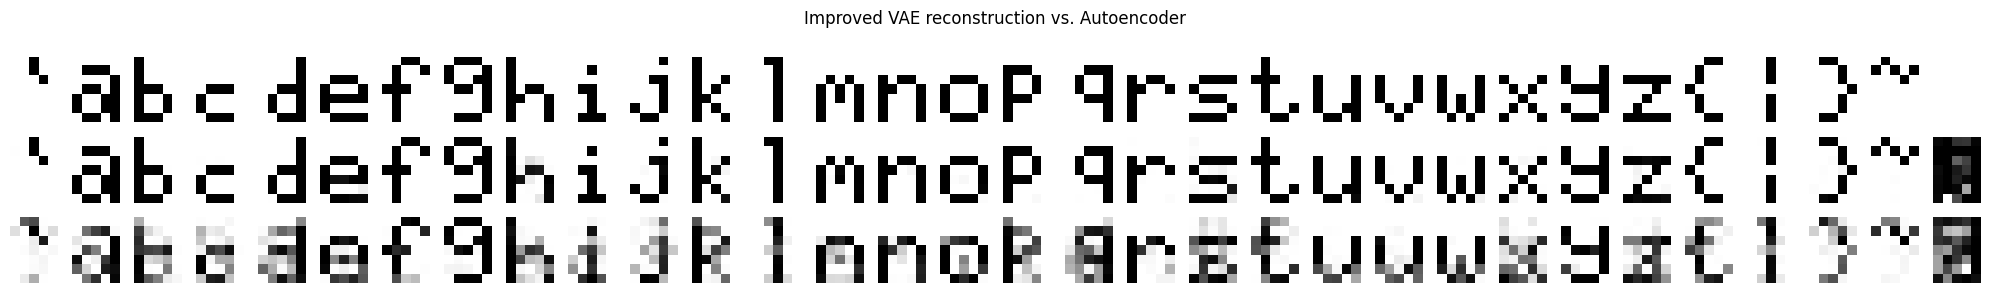

In [171]:
# Improved FontVAE and comparison with Autoencoder

# 1. Define a deeper VAE model for font characters
class ImprovedFontVAE(nn.Module):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(35, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(32, latent_dim)
        self.fc_logvar = nn.Linear(32, latent_dim)
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 35),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar

# 2. Prepare the font character data
X_font = torch.tensor(font_array, dtype=torch.float32)
font_dataset = TensorDataset(X_font)
font_loader = DataLoader(font_dataset, batch_size=8, shuffle=True)

# 3. Instantiate and train the improved VAE
font_vae = ImprovedFontVAE()
optimizer = torch.optim.Adam(font_vae.parameters(), lr=0.0005)

# Loss function with optional beta tuning (set beta=1.0 for standard VAE)
beta = 1.0

def vae_loss(recon_x, x, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return (recon_loss + beta * kl_div) / x.size(0)

for epoch in range(2000):
    for batch in font_loader:
        x = batch[0]
        optimizer.zero_grad()
        recon_x, mu, logvar = font_vae(x)
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()
    if epoch % 200 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# 4. Visual comparison: Original vs Autoencoder vs Improved VAE
with torch.no_grad():
    ae_recon = model(X_font).numpy()# Original autoencoder output
    vae_recon, _, _ = font_vae(X_font)  # Improved VAE output
    vae_recon = vae_recon.numpy()

fig, axs = plt.subplots(3, 32, figsize=(20, 3))
for i in range(32):
    axs[0, i].imshow(X_font[i].reshape(7, 5), cmap='binary') # Original
    axs[1, i].imshow(ae_recon[i].reshape(7, 5), cmap='binary') # Autoencoder
    axs[2, i].imshow(vae_recon[i].reshape(7, 5), cmap='binary') # VAE
    for j in range(3):
        axs[j, i].axis('off')

axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Autoencoder")
axs[2, 0].set_ylabel("VAE")
plt.suptitle("Improved VAE reconstruction vs. Autoencoder")
plt.tight_layout()
plt.show()


## Final Conclusion

Throughout this work, we explored both standard and variational autoencoders (VAE) using binary character data represented as 7×5 grids.

In **Task 1**, we focused on the original dataset of 32 font characters. We:
- Designed and trained a basic autoencoder with a 2D latent space,
- Experimented with deeper architectures to improve reconstruction accuracy,
- Visualized the latent space to understand how characters are embedded,
- Demonstrated generative capability by interpolating between character embeddings,
- Implemented a denoising autoencoder to restore noisy inputs.

The autoencoder achieved nearly perfect reconstructions on the training data, and the learned latent space showed meaningful structure.

In **Task 2**, we shifted toward generation and generalization:
- We constructed a new dataset of emoji-like binary patterns,
- Trained a Variational Autoencoder (VAE) to learn a continuous and structured latent space,
- Visualized the mean latent vectors (`μ`) of the inputs,
- Generated new emoji-like patterns by sampling from the latent space,
- Additionally, we trained a separate VAE on the original font dataset to compare it fairly with the autoencoder.

The VAE trained on emojis was able to generalize from limited samples and produce new, coherent outputs. The VAE trained on font characters performed worse in terms of pixel-perfect accuracy, but this is an expected tradeoff for gaining a smooth and generative latent representation.

Overall, this project demonstrated:
- The strength of autoencoders for accurate reconstruction,
- The value of VAEs for structured generation,
- How latent spaces can be visualized and manipulated meaningfully.

This sets a strong foundation for further work in generative models and latent space learning.
